# Bi-clustering and co-clustering from selected features

## Load dataset

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('aml_with_feature_selection_1.csv', sep=",", on_bad_lines="skip")
# Extract the first row and assign it as column names
#data.columns = data.iloc[0]
#data = data[1:]
# Reset index
data.reset_index(drop=True, inplace=True)
print(data.head())
print("\nMatrix dimensions:", data.shape)

   X..100130426  X..391343  ABCA17P.650655  ...  hsa.mir.9.1  hsa.mir.9.2  Death
0     -0.481788  -0.407763       -1.891932  ...     1.256781     1.027958    1.0
1     -0.481788  -0.407763        0.551149  ...    -0.542618    -0.294808    1.0
2     -0.481788  -0.407763        0.507044  ...    -0.578112    -0.404054    1.0
3      2.094436  -0.407763        0.313722  ...     0.196299     0.226374    1.0
4     -0.481788  -0.407763        0.227547  ...    -0.822727    -0.617406    0.0

[5 rows x 1072 columns]

Matrix dimensions: (159, 1072)


## Data preprocessing

In [2]:
# Define X: all columns from the second to the second-to-last
X = data.iloc[:, 0:-1]  # Excludes the first and the last two columns

# Define Y: last column (without modifications)
y = data.iloc[:, -1].astype(float)  # Ensure Y is numeric

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (159, 1071)
y shape: (159,)


## Number of clusters calculation (silhouette score)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralCoclustering, SpectralBiclustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, consensus_score

Optimal number of clusters based on silhouette score: k = 2


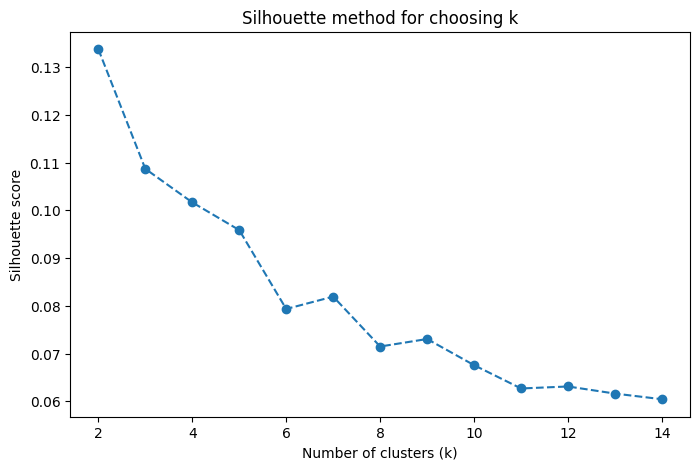

In [4]:
X_clustering = X

# Test multiple numbers of clusters
range_n_clusters = list(range(2, 15))  # Test k=2 to k=14
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_clustering)

    # Compute the silhouette score
    silhouette_avg = silhouette_score(X_clustering, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Find the optimal k
best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: k = {best_k}")

# Visualize silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='--')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette method for choosing k")
plt.show()

## Apply bi-clustering and co-clustering

In [6]:
def plot_matrix(matrix, title, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(12, 20))  # Make the figure larger
    ax.set_aspect('auto')
    cax = ax.matshow(matrix, cmap=cmap)
    plt.title(title, pad=20, fontsize=16)

    # Add colorbar with an appropriate size
    cbar = fig.colorbar(cax, ax=ax, fraction=0.02, pad=0.04)  # Adjust the colorbar size
    cbar.ax.tick_params(labelsize=12)  # Increase the size of colorbar labels

    # Adjust Y-axis labels
    n_rows = matrix.shape[0]
    step = max(1, n_rows // 10)  # Show only 10 labels on the Y-axis
    y_ticks = np.arange(0, n_rows, step)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks, fontsize=12)  # Increase label size

    # Adjust X-axis labels
    n_cols = matrix.shape[1]
    step = max(1, n_cols // 10)  # Show only 10 labels on the X-axis
    x_ticks = np.arange(0, n_cols, step)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticks, fontsize=12)  # Increase label size

    plt.show()

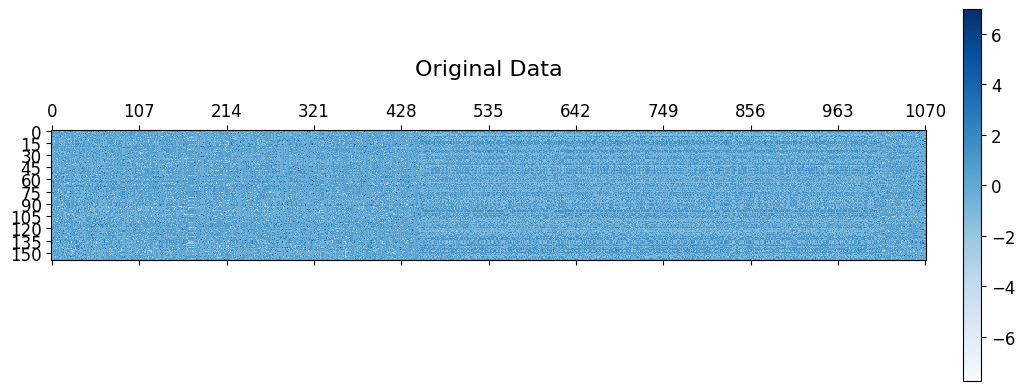

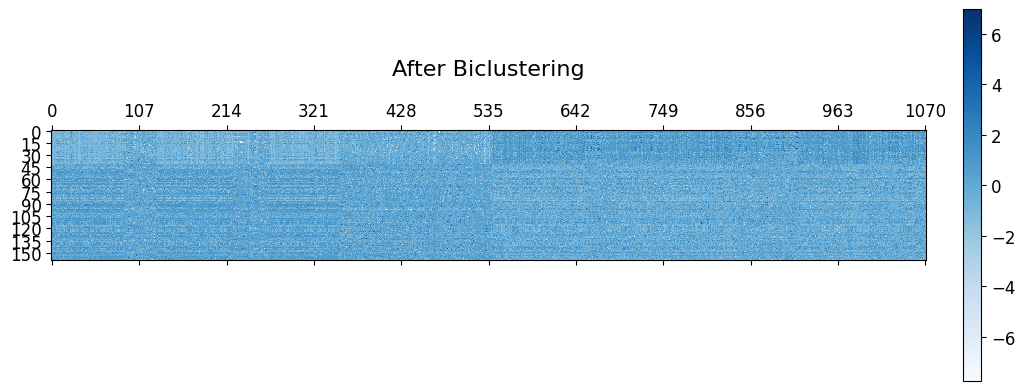

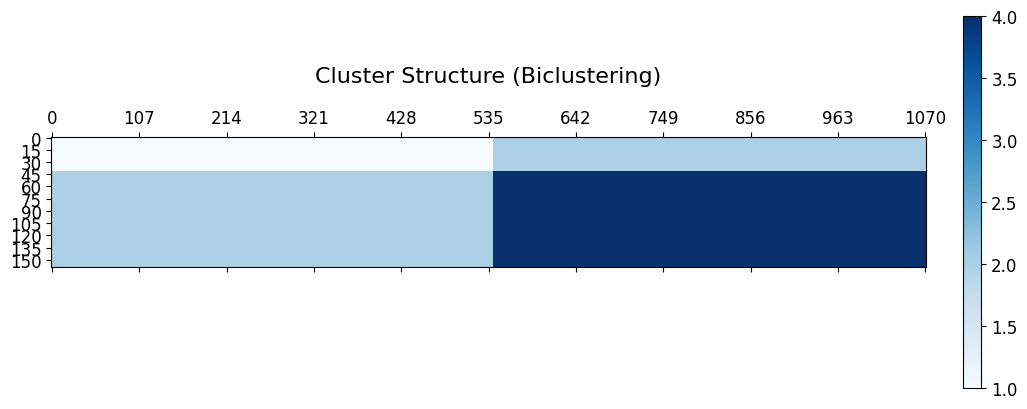

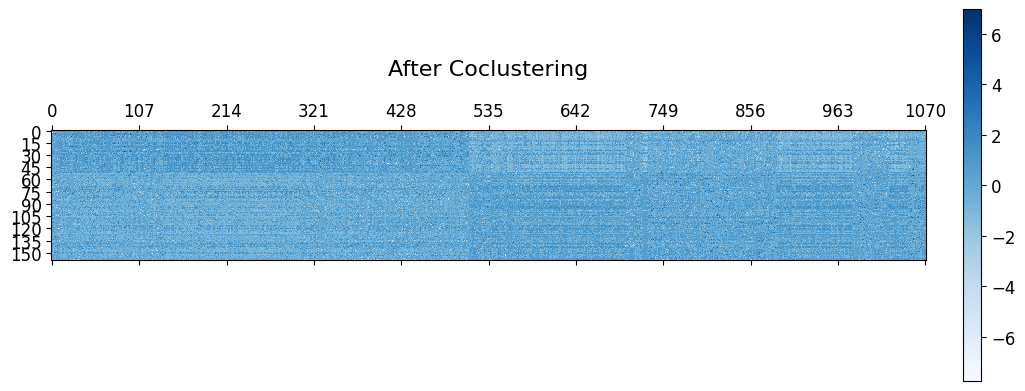

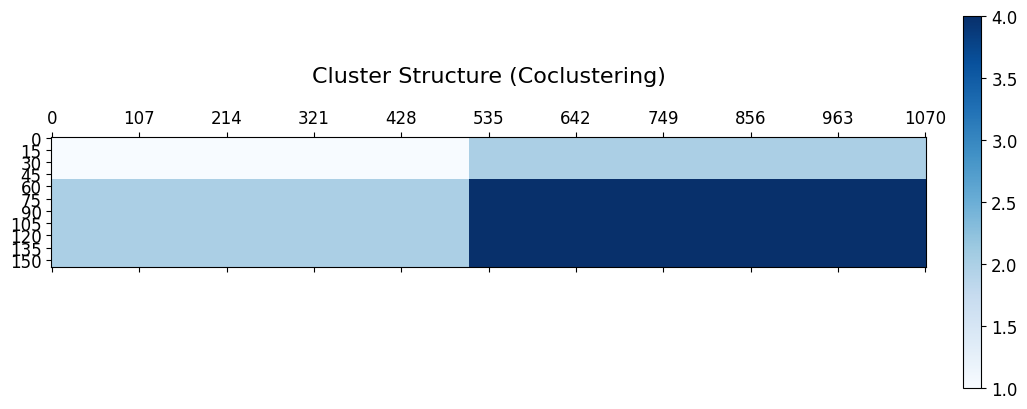

In [8]:
# Assume you have a dataframe called X
data_t = X.to_numpy()

# Cluster configuration
n_clusters = best_k

# --- Original State ---
plot_matrix(data_t, "Original Data")

# --- SpectralBiclustering ---
# Apply SpectralBiclustering
model_biclust = SpectralBiclustering(n_clusters=(n_clusters, n_clusters), method="log", random_state=0)
model_biclust.fit(data_t)

# Reorder rows and columns based on the found clusters
fit_data_biclust = data_t[np.argsort(model_biclust.row_labels_)]
fit_data_biclust = fit_data_biclust[:, np.argsort(model_biclust.column_labels_)]

# Visualize Biclustering results
plot_matrix(fit_data_biclust, "After Biclustering")

# Visualize cluster structure for Biclustering
cluster_structure_biclust = np.outer(np.sort(model_biclust.row_labels_) + 1, np.sort(model_biclust.column_labels_) + 1)
plot_matrix(cluster_structure_biclust, "Cluster Structure (Biclustering)")

# --- SpectralCoclustering ---
# Apply SpectralCoclustering
model_coclust = SpectralCoclustering(n_clusters=n_clusters, random_state=0)
model_coclust.fit(data_t)

# Reorder rows and columns based on the found clusters
fit_data_coclust = data_t[np.argsort(model_coclust.row_labels_)]
fit_data_coclust = fit_data_coclust[:, np.argsort(model_coclust.column_labels_)]

# Visualize Coclustering results
plot_matrix(fit_data_coclust, "After Coclustering")

# Visualize cluster structure for Coclustering
cluster_structure_coclust = np.outer(np.sort(model_coclust.row_labels_) + 1, np.sort(model_coclust.column_labels_) + 1)
plot_matrix(cluster_structure_coclust, "Cluster Structure (Coclustering)")

## Comparing results for co-clustering and bi-clustering

### Co-clustering

In [9]:
# Retrieve clusters
row_clusters_coclust = model_coclust.row_labels_  # Patient clusters
col_clusters_coclust = model_coclust.column_labels_  # Variable clusters

# Add clusters to the DataFrame
data["Cluster_Patient_Coclust"] = row_clusters_coclust

print(data[["Death", "Cluster_Patient_Coclust"]].head())

   Death  Cluster_Patient_Coclust
0    1.0                        1
1    1.0                        1
2    1.0                        1
3    1.0                        1
4    0.0                        0


In [11]:
# Display the number of patients and variables per cluster
unique_patient_clusters_coclust, patient_counts_coclust = np.unique(row_clusters_coclust, return_counts=True)
unique_variable_clusters_coclust, variable_counts_coclust = np.unique(col_clusters_coclust, return_counts=True)

print("Number of patients per cluster (Coclustering):")
for cluster, count in zip(unique_patient_clusters_coclust, patient_counts_coclust):
    print(f"Cluster {cluster}: {count} patients")

print("\nNumber of variables per cluster (Coclustering):")
for cluster, count in zip(unique_variable_clusters_coclust, variable_counts_coclust):
    print(f"Cluster {cluster}: {count} variables")

Number of patients per cluster (Coclustering):
Cluster 0: 51 patients
Cluster 1: 108 patients

Number of variables per cluster (Coclustering):
Cluster 0: 512 variables
Cluster 1: 559 variables


### Bi-clustering

In [12]:
# Retrieve clusters
row_clusters_biclust = model_biclust.row_labels_  # Patient clusters
col_clusters_biclust = model_biclust.column_labels_  # Variable clusters

# Add clusters to the DataFrame
data["Cluster_Patient_Biclust"] = row_clusters_biclust

print(data[["Death", "Cluster_Patient_Biclust"]].head())

   Death  Cluster_Patient_Biclust
0    1.0                        1
1    1.0                        1
2    1.0                        1
3    1.0                        1
4    0.0                        0


In [13]:
# Display the number of patients and variables per cluster
unique_patient_clusters_biclust, patient_counts_biclust = np.unique(row_clusters_biclust, return_counts=True)
unique_variable_clusters_biclust, variable_counts_biclust = np.unique(col_clusters_biclust, return_counts=True)

print("Number of patients per cluster (Biclustering):")
for cluster, count in zip(unique_patient_clusters_biclust, patient_counts_biclust):
    print(f"Cluster {cluster}: {count} patients")

print("\nNumber of variables per cluster (Biclustering):")
for cluster, count in zip(unique_variable_clusters_biclust, variable_counts_biclust):
    print(f"Cluster {cluster}: {count} variables")

Number of patients per cluster (Biclustering):
Cluster 0: 42 patients
Cluster 1: 117 patients

Number of variables per cluster (Biclustering):
Cluster 0: 541 variables
Cluster 1: 530 variables
